In [74]:
import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import pdb
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize'] = (15,10)
sns.set()

In [2]:
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
dt = 1/48
month_list = [i for i in range(1,13)] 
PowerTheta = np.zeros(12)
GasTheta = np.zeros(12)

In [3]:
def func1(N,    #N is the number of periods
    PowerPrices = Power, 
    GasPrices = Gas,
    thetap1= PowerTheta,
    thetag1 = GasTheta,
    rho = 0.3,   
    n = 100 ,
    random_seed = 100): #number of paths
    
    #params
    N_month = N
    N *= 4
    alphaCC,alphaJC,alphaG = 7, 20, 3
    m = 75
    p = 0.083 # lambda*dt, weekly probability
    CC0, JC0, G0 = 35, 0, 3
    spike_thres = 75
    sigmaG = 7.22/np.sqrt(dt)/100
    
    #V summer and winter
    v_summer = 28.87/np.sqrt(dt)/100
    v_winter = 10.83/np.sqrt(dt)/100
    V = np.zeros((N+1,n))
    
    W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    CC = np.zeros((N+1,n)) 
    CC[0,:] = CC0
    JC = np.zeros((N+1,n))
    JC[0,:] = JC0
    G = np.zeros((N+1,n)) 
    G[0,:] = G0
    PC = np.zeros((N+1,n))
    PC[0,:] = CC[0,:]
    # 
    Power_MSE,Gas_MSE = 0, 0
    Power_Price_Fit, Gas_Price_Fit, CC_Price_Fit, JC_Price_Fit = list(), list(), list(), list()

    
    for i in range(1, N + 1):
        month1 = month_list[int(np.ceil(i/4)) - 1]    
        monthIndicator = (month1 > 4)&(month1 < 9)

        V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
        CC[i,:] = alphaCC*(thetap1[month1-1] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
        JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
        #Power Price
        PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:] > spike_thres)
        #Gas Price
        G[i,:]  = alphaG*(thetag1[month1-1] - G[i-1,:])*dt + sigmaG * G[i-1,:] * B[i,:] + G[i-1,:]

        Power_MSE += np.abs(np.mean(PC[i,:]) - PowerPrices[month1 - 1])
        Gas_MSE += np.abs(np.mean(G[i,:]) - GasPrices[month1 - 1])
        
        if i%4 == 0:
            Power_Price_Fit.append(np.mean(PC[i,:]))
            Gas_Price_Fit.append(np.mean(G[i,:]))
            CC_Price_Fit.append(np.mean(CC[i,:]))
            JC_Price_Fit.append(np.mean(JC[i,:]))
            
    return Power_MSE, Gas_MSE,(Power_Price_Fit,Gas_Price_Fit,CC_Price_Fit,JC_Price_Fit)
    

In [4]:
def cali(MSE_fun, N, thetap_l = 0, thetap_r = 300, thetap_d = 0.5, thetag_l = 0, thetag_r = 10, thetag_d = 0.05):
    MSE_p, MSE_g = list(), list()
    thetap_list = [thetap_l + thetap_d * x for x in range(int((thetap_r -thetap_l)/thetap_d)+1)]
    thetag_list = [thetag_l + thetag_d * x for x in range(int((thetag_r - thetag_l)/thetag_d)+1)]
    for i1 in thetap_list:
        PowerTheta[N - 1] = i1
        MSE_p.append(MSE_fun(N, Power,Gas,thetap1= PowerTheta, thetag1 = GasTheta,rho = 0.3,n = 100)[0])
        #print("MSE_P:", MSE_p)
        #print(PowerTheta)
    for i2 in thetag_list:
        GasTheta[N - 1] = i2
        MSE_g.append(MSE_fun(N, Power,Gas,thetap1= PowerTheta,thetag1 = GasTheta,rho = 0.3,n = 100)[1])
    #print('MSE\n',MSE_p)
    #print('index\n',np.argmin(MSE_p))
    #print('thetap\n',thetap_list[np.argmin(MSE_p)])
    return thetap_list[np.argmin(MSE_p)], thetag_list[np.argmin(MSE_g)], np.min(MSE_p), np.min(MSE_g)
    

In [15]:
# np.random.seed(10)
num = 30
PowerTheta = np.zeros(12)
GasTheta = np.zeros(12)
PowerTheta_m = np.zeros((num, 12))
GasTheta_m = np.zeros((num, 12))
for time in range(30):
    print(time)
    for n in range(1, 13):
        print("This is the", n ,"for loop")
        PowerTheta[n-1], GasTheta[n-1], MSE_P, MSE_G  = cali(func1, N = n)
#         print(PowerTheta)
#         print(GasTheta)
#         print(MSE_P)
#         print(MSE_G)
    PowerTheta_m[time, :], GasTheta_m[time, :] = PowerTheta, GasTheta

0
This is the 1 for loop
This is the 2 for loop
This is the 3 for loop
This is the 4 for loop
This is the 5 for loop
This is the 6 for loop
This is the 7 for loop
This is the 8 for loop
This is the 9 for loop
This is the 10 for loop
This is the 11 for loop
This is the 12 for loop
1
This is the 1 for loop
This is the 2 for loop
This is the 3 for loop
This is the 4 for loop
This is the 5 for loop
This is the 6 for loop
This is the 7 for loop
This is the 8 for loop
This is the 9 for loop
This is the 10 for loop
This is the 11 for loop
This is the 12 for loop
2
This is the 1 for loop
This is the 2 for loop
This is the 3 for loop
This is the 4 for loop
This is the 5 for loop
This is the 6 for loop
This is the 7 for loop
This is the 8 for loop
This is the 9 for loop
This is the 10 for loop
This is the 11 for loop
This is the 12 for loop
3
This is the 1 for loop
This is the 2 for loop
This is the 3 for loop
This is the 4 for loop
This is the 5 for loop
This is the 6 for loop
This is the 7 for

This is the 2 for loop
This is the 3 for loop
This is the 4 for loop
This is the 5 for loop
This is the 6 for loop
This is the 7 for loop
This is the 8 for loop
This is the 9 for loop
This is the 10 for loop
This is the 11 for loop
This is the 12 for loop


In [21]:
PowerTheta_m.mean(axis=0).round(2)

array([ 39.28,  40.65,  40.48,  42.75,  46.62,  71.88,  86.92, 103.63,
        60.78,  35.55,  39.67,  44.47])

In [22]:
GasTheta_m.mean(axis=0).round(2)

array([2.51, 2.49, 2.66, 2.59, 5.28, 6.33, 6.39, 5.93, 3.12, 2.73, 2.02,
       3.07])

In [23]:
PowerTheta_m.std(axis=0).round(2)

array([ 1.45,  1.92,  2.36,  2.65,  5.01,  8.66, 12.21, 13.79, 12.78,
       14.01, 12.77, 10.9 ])

In [24]:
GasTheta_m.std(axis=0).round(2)

array([0.17, 0.2 , 0.28, 0.4 , 0.43, 0.67, 0.48, 0.53, 0.45, 0.78, 0.84,
       0.71])

In [ ]:
[0.17, 0.2, 0.28, 0.4, 0.43, 0.67, 0.48, 0.53, 0.45, 0.78, 0.84, 0.71]

Power Price Fit:  [37.826943990272035, 37.57292131786199, 38.92782043451271, 40.18816830193782, 42.457657999853176, 58.73522645678722, 61.91401452475172, 105.00420963685747, 107.61208124383819, 66.1902204854646, 68.42841901676822, 41.51972495714192] 

CC Price Fit:  [37.826943990272035, 37.57292131786199, 38.92782043451271, 40.18816830193782, 37.95361901458671, 56.8229937272368, 61.642277380833, 83.50960800783356, 77.59049840875602, 64.24145961699972, 51.839257856043474, 41.10811599605044] 

JC_Price_Fit:  [25.520833333333343, 43.363017015496396, 5.020958905006119, 0.5813716401870996, 75.06731642110768, 8.691966952501913, 1.0064338663656003, 43.86653393678357, 45.48724671982142, 5.266921266121301, 59.24700414544546, 6.860149351524623] 

real Power Price:  [36.63 38.26 39.39 40.56 43.23 56.54 72.7  84.19 76.06 61.32 50.75 46.9 ] 

Gas_Price_Fit:  [2.8889300280203893, 2.7931236621626097, 2.7605450567911216, 2.6147181310445196, 3.297285770032098, 3.76715056042682, 4.373828910309083, 4.975

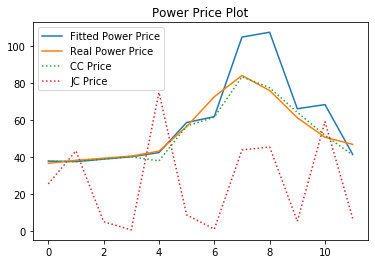

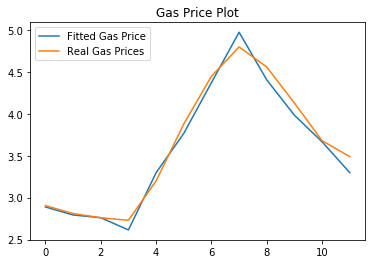

In [6]:
result = func1(12, Power,Gas,thetap1= PowerTheta, thetag1 = GasTheta,rho = 0.3,n = 100)[2]

Power_Price_Fit,Gas_Price_Fit,CC_Price_Fit,JC_Price_Fit = result

fig = plt.figure()
plt.plot(Power_Price_Fit,label = 'Fitted Power Price')
plt.plot(Power,label = 'Real Power Price')
plt.plot(CC_Price_Fit,label = 'CC Price',linestyle = "dotted")
plt.plot(JC_Price_Fit,label = 'JC Price',linestyle = "dotted")
plt.title('Power Price Plot')
plt.legend()

fig = plt.figure()
plt.plot(Gas_Price_Fit,label = 'Fitted Gas Price')
plt.plot(Gas,label = 'Real Gas Prices')
plt.title('Gas Price Plot')
plt.legend()

print('Power Price Fit: ',Power_Price_Fit,'\n')
print('CC Price Fit: ',CC_Price_Fit,'\n')
print('JC_Price_Fit: ',JC_Price_Fit,'\n')
print('real Power Price: ', Power,'\n')
print('Gas_Price_Fit: ',Gas_Price_Fit,'\n')
print('Gas Prices: ',Gas,'\n')

### Sensitivity Test

In [71]:
def sen_test(eval_para_pos, PowerPrices = Power, GasPrices = Gas, thetap1= PowerTheta, thetag1 = GasTheta,
             n = 5000):
    #params
    N_month = 12
    N = 12
    N *= 4
    p_theta_std = np.array([1.45, 1.92, 2.36, 2.65, 5.01, 8.66, 12.21, 13.79, 12.78, 14.01, 12.77, 10.9])
    g_theta_std = np.array([0.17, 0.2, 0.28, 0.4, 0.43, 0.67, 0.48, 0.53, 0.45, 0.78, 0.84, 0.71])
    variable_list = [7, 20, 3, 75, 0.083, 35, 0, 3, 75, 7.22, 0.3, 28.87, 10.83, np.array(thetap1), np.array(thetag1)]
    variables_names = ['alphaCC', 'alphaJC', 'alphaG', 
                       'm', 'p', 'CC0', 'JC0', 'G0',
                       'spike_thres', 'sigmaG', 'rho', 
                       'v_summer', 'v_winter', 'PowerTheta', 'GasTheta']
    vec_res_p = list()
    vec_res_g = list()
    num_se = 3
    
    if eval_para_pos == 3:
        new_variable = np.array([75 - num_se * 5, 75, 75 + num_se * 5])
    elif eval_para_pos == 4:
        new_variable = np.array([0.083 - num_se * 0.005, 0.083, 0.083 + num_se * 0.005])
    elif eval_para_pos == 9:
        new_variable = np.array([7.22 - num_se * 0.05, 7.22, 7.22 + num_se * 0.05]) / np.sqrt(dt) / 100
    elif eval_para_pos == 10:
        new_variable = np.array([0.3 - num_se * 0.05, 0.3, 0.3 + num_se * 0.05])    
    elif eval_para_pos == 11:
        new_variable = np.array([28.87 - num_se * 2, 28.87, 28.87 + num_se * 2]) / np.sqrt(dt) / 100
    elif eval_para_pos == 12:
        new_variable = np.array([10.83 - num_se * 2, 10.83, 10.83 + num_se * 2]) / np.sqrt(dt) / 100
    elif eval_para_pos == 13:
        new_variable = np.array([variable_list[13] - num_se * p_theta_std, 
                                 variable_list[13],
                                 variable_list[13] + num_se * p_theta_std])
    elif eval_para_pos == 14:
        new_variable = np.array([variable_list[14] - num_se * g_theta_std, 
                                 variable_list[14],
                                 variable_list[14] + num_se * g_theta_std])
    
    for ix in range(len(new_variable)):
        variable_list[eval_para_pos] = new_variable[ix]
        alphaCC  = variable_list[0]
        alphaJC  = variable_list[1]
        alphaG  = variable_list[2]
        m  = variable_list[3]
        p  = variable_list[4]
        CC0  = variable_list[5]
        JC0  = variable_list[6]
        G0  = variable_list[7]
        spike_thres  = variable_list[8]
        sigmaG  = variable_list[9]/np.sqrt(dt)/100
        rho  = variable_list[10]
        v_summer  = variable_list[11]/np.sqrt(dt)/100
        v_winter  = variable_list[12]/np.sqrt(dt)/100
        PowerTheta  = variable_list[13]
        GasTheta  = variable_list[14]

        V = np.zeros((N+1,n))
        W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
        Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
        B = rho*W + np.sqrt(1-rho**2)*Wtilde

        CC = np.zeros((N+1,n)) 
        CC[0,:] = CC0
        JC = np.zeros((N+1,n))
        JC[0,:] = JC0
        G = np.zeros((N+1,n)) 
        G[0,:] = G0
        PC = np.zeros((N+1,n))
        PC[0,:] = CC[0,:]
        Power_MSE,Gas_MSE = 0, 0
        Power_Price_Fit, Gas_Price_Fit, CC_Price_Fit, JC_Price_Fit = list(), list(), list(), list()


        for i in range(1, N + 1):
            month1 = month_list[int(np.ceil(i/4)) - 1]    
            monthIndicator = (month1 > 4)&(month1 < 9)

            V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
            CC[i,:] = alphaCC*(thetap1[month1-1] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
            JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
            #Power Price
            PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:] > spike_thres)
            #Gas Price
            G[i,:]  = alphaG*(thetag1[month1-1] - G[i-1,:])*dt + sigmaG * G[i-1,:] * B[i,:] + G[i-1,:]

            Power_MSE += np.abs(np.mean(PC[i,:]) - PowerPrices[month1 - 1])
            Gas_MSE += np.abs(np.mean(G[i,:]) - GasPrices[month1 - 1])
            
            if i%4 == 0:
                Power_Price_Fit.append(np.mean(PC[i,:]))
                Gas_Price_Fit.append(np.mean(G[i,:]))
                CC_Price_Fit.append(np.mean(CC[i,:]))
                JC_Price_Fit.append(np.mean(JC[i,:]))
#         MSE_p[ix] = Power_MSE
#         MSE_g[ix] = Gas_MSE
        
        vec_res_p.append(Power_Price_Fit)
        vec_res_g.append(Gas_Price_Fit)
        
    power_lines = pd.DataFrame(vec_res_p).T
    power_lines.columns = ['cali_values 3 * SE down shift', 'cali_values', 'cali_values 3 * SE up shift']
    power_lines['real_value'] = Power

    gas_lines = pd.DataFrame(vec_res_g).T
    gas_lines.columns = ['cali_values 3 * SE down shift', 'cali_values', 'cali_values 3 * SE up shift']
    gas_lines['real_value'] = Gas

    if eval_para_pos in [3, 4, 11, 12, 13]:
        power_lines.plot(style=['b-', 'r-', 'g-', 'y--'])
        plt.title('Power Prices (Real & Calibrated)')
    elif eval_para_pos in [9, 14]:
        gas_lines.plot()
        plt.title('Gas Prices (Real & Calibrated)')
    elif eval_para_pos == 10:
        power_lines.plot()
        plt.title('Power Prices (Real & Calibrated)')
        gas_lines.plot()
        plt.title('Gas Prices (Real & Calibrated)')
        
#     return MSE_p, MSE_g, vec_res
#     return vec_res

In [45]:
theta_po = [39.28, 40.65, 40.48, 42.75, 46.62, 71.88, 86.92, 103.63, 60.78, 35.55, 39.67, 44.47]
theta_ga = [2.51, 2.49, 2.66, 2.59, 5.28, 6.33, 6.39, 5.93, 3.12, 2.73, 2.02, 3.07]
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
dt = 1/48
multiplier = np.arange(0.5, 1.52, 0.02)

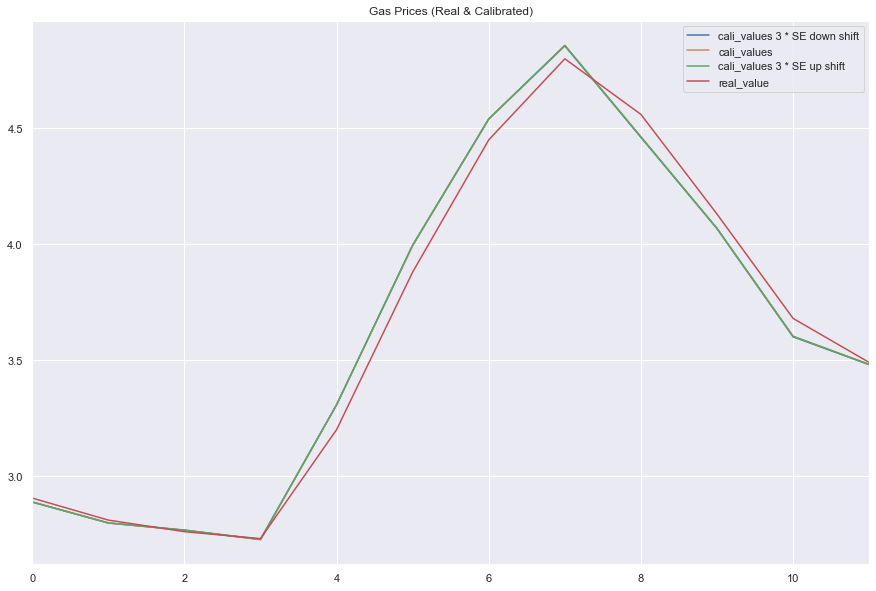

In [75]:
sen_test(9, multiplier, thetap1=theta_po, thetag1=theta_ga)

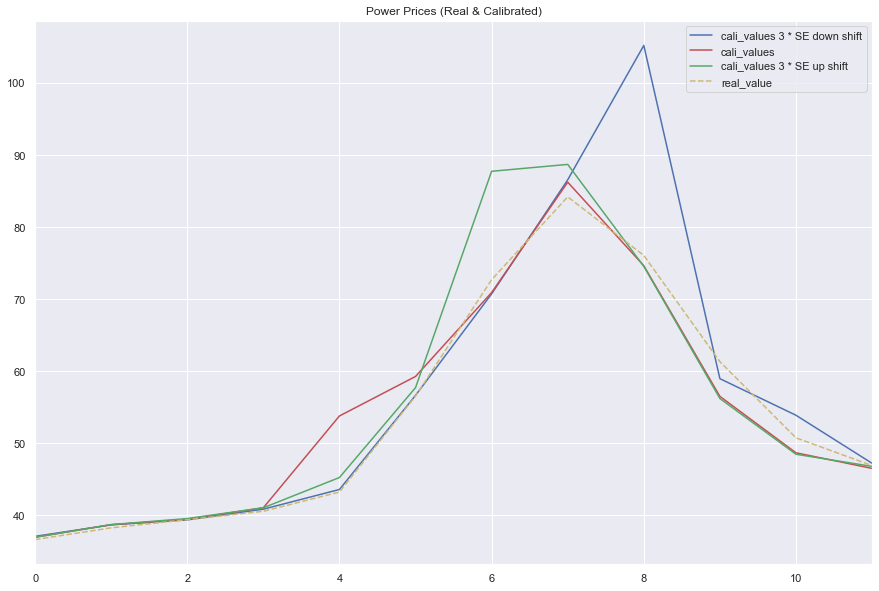

In [85]:
sen_test(13, multiplier, thetap1=theta_po, thetag1=theta_ga)